In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

import codecs
import re
import os.path
import common as cmn

# Données reconnaissance du locuteur (Chirac/Mitterrand)

In [2]:
fname = "../datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = cmn.load_pres(fname)

In [3]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])


57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.
1


# 0) Analyse exploratrice des données :

In [4]:
# Création d'un dataframe pour notre base de données :
data_frame_discours = pd.DataFrame()
data_frame_discours['text'] = alltxts
data_frame_discours['label'] = alllabs
data_frame_discours

,text,label
0,"Quand je dis chers amis, il ne s'agit pas là ...",1
1,D'abord merci de cet exceptionnel accueil que...,1
2,C'est toujours très émouvant de venir en Afri...,1
3,Aucun citoyen français ne peut être indiffére...,1
4,"Le Congo, que naguère le <nom> qualifia de ""r...",1
...,...,...
57408,Je suis heureux de le mener avec vous.\n,1
57409,"Vous le savez, comme vous, j'ai la passion de...",1
57410,Je crois en son avenir.\n,1
57411,"Je crois en la politique, c'est-à-dire en not...",1


In [5]:
counter = Counter( alllabs)
print("Nombre de texts : ", len(alllabs))
print("----> # de C : ", counter[1])
print("----> # de M : ", counter[-1])

Nombre de texts :  57413
----> # de C :  49890
----> # de M :  7523


##### Visualisation de la proportion des deux classes :
-   Afin de bien visualiser la distribution de celles ci nous procédons ainsi : 

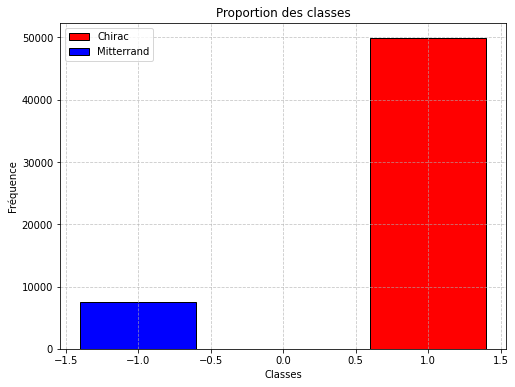

In [6]:
classes = list(counter.keys())
frequences = list(counter.values())

plt.figure(figsize=(8, 6)) 

# On crée un diagramme à barres
bars = plt.bar(classes, frequences, color=['red', 'blue'],edgecolor="black")

# On ajoute des titres et des étiquettes
plt.title('Proportion des classes')
plt.xlabel('Classes')
plt.ylabel('Fréquence')
plt.legend(bars, ['Chirac', 'Mitterrand'])

plt.grid(True, linestyle='--', alpha=0.7)

# On afffiche
plt.show()

<Axes: ylabel='count'>

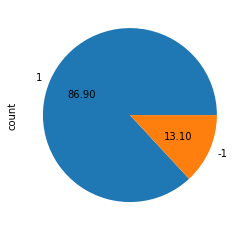

In [7]:
data_frame_discours['label'].value_counts().plot.pie(autopct='%.2f')

 On identifie un déséquilibre significatif entre les classes de nos échantillons. Cette disparité est particulièrement visible dans la différence de fréquence entre les phrases dites par Chirac et celles dites par Mitterrand. En effet, nos résultats révèlent que le nombre de phrases attribuées à Chirac est nettement supérieur à celui attribué à Mitterrand.

#### Visualisation de la disctribution des longueurs de text prononcés par nos deux locuteurs :

In [8]:
data_frame_discours['length_txt']= data_frame_discours['text'].apply(len)
data_frame_discours

,text,label,length_txt
0,"Quand je dis chers amis, il ne s'agit pas là ...",1,117
1,D'abord merci de cet exceptionnel accueil que...,1,113
2,C'est toujours très émouvant de venir en Afri...,1,304
3,Aucun citoyen français ne peut être indiffére...,1,76
4,"Le Congo, que naguère le <nom> qualifia de ""r...",1,187
...,...,...,...
57408,Je suis heureux de le mener avec vous.\n,1,40
57409,"Vous le savez, comme vous, j'ai la passion de...",1,58
57410,Je crois en son avenir.\n,1,25
57411,"Je crois en la politique, c'est-à-dire en not...",1,96


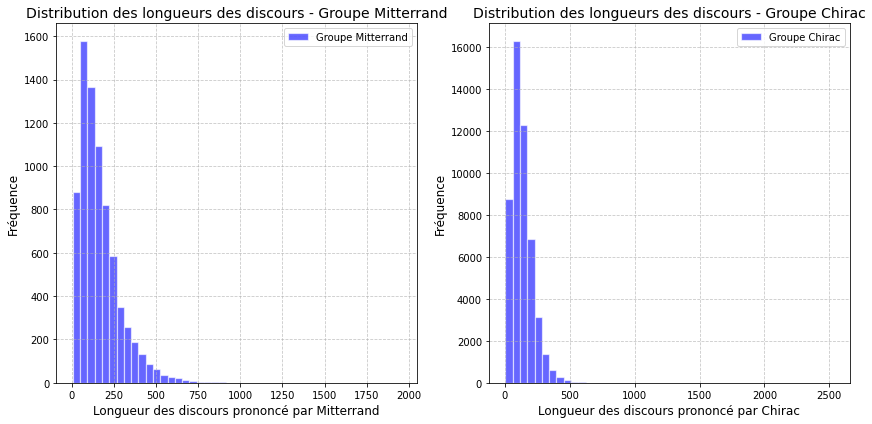

In [9]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 2 sous-tracés côte à côte

# Diviser les données des CHirac et Mitterand en fonction des lables
groupes = data_frame_discours.groupby('label')['length_txt']

# Tracer un histogramme pour chaque groupe
for i, (groupe_name, groupe_data) in enumerate(groupes):
    groupe_name = "Mitterrand" if groupe_name == -1 else  "Chirac"

    axs[i].hist(groupe_data, bins=45, alpha=0.6, label=f'Groupe {groupe_name}', color='blue', edgecolor='white', linewidth=1.2)
    
    #POur avoir une grille
    axs[i].grid(True, linestyle='--', alpha=0.7)

    # On ajouter des titres et des étiquettes
    axs[i].set_title(f'Distribution des longueurs des discours - Groupe {groupe_name}', fontsize=14)
    axs[i].set_xlabel(f'Longueur des discours prononcé par {groupe_name}', fontsize=12)
    axs[i].set_ylabel('Fréquence', fontsize=12)

    axs[i].legend()

# On affiche les sous-graphiques
plt.tight_layout()
plt.show()

-   Essayons d'afficher la plus grande phrase ainsi que ces proprités :

In [10]:
#data_frame_discours[data_frame_discours['length_txt'] == data_frame_discours['length_txt'].max()]['text'].iloc[0]
print("La taille de la plus longue phrase prononcée : ",data_frame_discours['length_txt'].max())
print("Dite par : ",data_frame_discours[data_frame_discours['length_txt'] == data_frame_discours['length_txt'].max()]['label'].iloc[0]) # ELle appartient a CHirac : 1

La taille de la plus longue phrase prononcée :  2530
Dite par :  1


# A) Transformation paramétrique du texte (pre-traitements)

On teste les cas suivants:
- suppression de la ponctuation
- transformation en minuscule ou pas
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- lemmatization 


Ici nous verifions d'abord dans un premier lieu l'ensemble des fonction qu'on va utiliser 

In [11]:
import string


#### A.1) Suppression de la ponctuation :  

In [12]:
text = data_frame_discours.text[0]
print("Avant :" ,text)
text =  cmn.suppression_ponctuation(data_frame_discours.text[0])
print("Apres :" ,text)


Avant :  Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

Apres :  Quand je dis chers amis  il ne s agit pas là d une formule diplomatique  mais de l expression de ce que je ressens  


#### A.2) Remplacer les mots entierelement en majuscule en marqueurs :

In [13]:
text = data_frame_discours.text[2467]
print("Avant :",text)
print("Apres :",cmn.majuscules_en_marqueurs(text))


Avant :  Les études de l'OMS et de l'ONUSIDA le démontrent : l'épidémie s'étend, en Asie, en Russie, dans les pays de la CEI, dans les pays d'Europe centrale et orientale.

Apres :  Les études de l'**OMS** et de l'**ONUSIDA** le démontrent : l'épidémie s'étend, en Asie, en Russie, dans les pays de la **CEI**, dans les pays d'Europe centrale et orientale.



#### A.3) Suppression des chiffres :

In [14]:
print(data_frame_discours.text[139])
print(cmn.suppression_chiffres(data_frame_discours.text[139]))

 Mes chers compatriotes, vous représentez Ici les quelques 30 000 Français du Maroc et je voudrais vous remercier d'avoir répondu à mon invitation, en effectuant pour certains le déplacement depuis Agadir, Tanger, Fès, Meknès, Marrakech ou d'autres régions du Royaume.

 Mes chers compatriotes, vous représentez Ici les quelques   Français du Maroc et je voudrais vous remercier d'avoir répondu à mon invitation, en effectuant pour certains le déplacement depuis Agadir, Tanger, Fès, Meknès, Marrakech ou d'autres régions du Royaume.



#### A.4) Suppression des balises HTML :

In [15]:
text = data_frame_discours.text[4]
print("Avant",text)
print("Apres",cmn.suppression_balises_html(text))

Avant  Le Congo, que naguère le <nom> qualifia de "refuge pour la liberté", de "base de départ pour la libération", de "môle pour la Résistance", comment ne pas être heureux de s'y retrouver ?

Apres  Le Congo, que naguère le  qualifia de "refuge pour la liberté", de "base de départ pour la libération", de "môle pour la Résistance", comment ne pas être heureux de s'y retrouver ?



#### A.5) Stemming :

In [16]:
text = data_frame_discours.text[0]
print("Avant :",text)
print("Apres :",cmn.stemming(text))

Avant :  Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

Apres : quand je dis cher amis , il ne s'ag pas là d'un formul diplomat , mais de l'express de ce que je ressen .


#### A.7) Conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...):


##### Seulement la première :

In [17]:
text = data_frame_discours.text[162]
print("Avant :",text)
print("Apres :",cmn.extraire_debut(text))

Avant :  Il suffit de se retourner de ce côté-là pour apercevoir de profil Saint-Flour qui n'est pas une ville négligeable par son architecture... des châteaux, des fermes, le parcellaire des terres, témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d'avoir créé une forme d'esthétique, la beauté de la France, à laquelle prend part, évidemment, la beauté de l'Auvergne.

Apres :  Il suffit de se retourner de ce côté-là pour apercevoir de profil Saint-Flour qui n'est pas une ville négligeable par son architecture


##### Seulement la dernière :

In [18]:
text = data_frame_discours.text[162]
print("Avant :",text)
print("Apres :",cmn.extraire_fin(text))

Avant :  Il suffit de se retourner de ce côté-là pour apercevoir de profil Saint-Flour qui n'est pas une ville négligeable par son architecture... des châteaux, des fermes, le parcellaire des terres, témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d'avoir créé une forme d'esthétique, la beauté de la France, à laquelle prend part, évidemment, la beauté de l'Auvergne.

Apres :  des châteaux, des fermes, le parcellaire des terres, témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d'avoir créé une forme d'esthétique, la beauté de la France, à laquelle prend part, évidemment, la beauté de l'Auvergne


#### Suppression des noms propres :

In [19]:

print("Avant :",text)
print("Apres :",cmn.remove_proper_nouns(text))

Avant :  Il suffit de se retourner de ce côté-là pour apercevoir de profil Saint-Flour qui n'est pas une ville négligeable par son architecture... des châteaux, des fermes, le parcellaire des terres, témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d'avoir créé une forme d'esthétique, la beauté de la France, à laquelle prend part, évidemment, la beauté de l'Auvergne.

Apres :   Il suffit de se retourner de ce côté -là pour apercevoir de profil qui n' est pas une ville négligeable par son architecture ... des châteaux , des fermes , le parcellaire des terres , témoins de tant de travail et de tant de réussites accumulés à travers les siècles au point d' avoir créé une forme d' esthétique , la beauté de la , à laquelle prend part , évidemment , la beauté de l' Auvergne . 



# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <BR>
 
-  **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

## 3) Post-processing sur les données Président

Pour la tâche de reconnaissance de locuteur, des phrases successives sont souvent associés à un même locuteur. Voir par exemples les 100 premiers labels de la base d'apprentissage. 

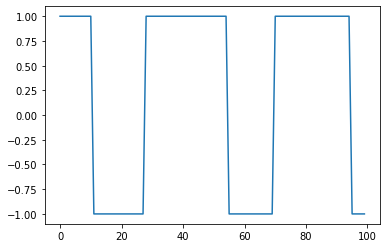

In [21]:
# fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
# alltxts,alllabs = cmn.load_pres(fname)

plt.figure()
plt.plot(list(range(len(alllabs[0:100]))),alllabs[0:100])

**Une méthode de post-traitement pour améliorer les résultats consistent à lisser les résultats de la prédictions d'une phrases par les prédictions voisines, en utilisant par exemple une convolution par une filtre Gaussien. Compléter la fonction ci-dessous et tester l'impact de ce lissage sur les performances.**

In [ ]:
def gaussian_smoothing(pred, size):
     # LISSAGE par un filtre Gaussien de taille size - vous pouvez utiliser np.convolve 
    return 0


## 4) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?